# Gallstone Risk Prediction for Private Clinic Checkups

## Business Context
This project targets a private-clinic annual checkup setting, where patients usually do not receive immediate gallbladder imaging at first visit.  

Our objective is to build a **non-imaging gallstone risk prediction model** from routine checkup variables and use it for early triage.  
The model output is a risk probability for screening prioritization, not a diagnostic replacement.


## Outline
1. Data loading and quality checks
2. Feature engineering and leakage-safe feature policy
3. EDA and multicollinearity diagnostics
4. Feature selection (MI, L1, RFECV)
5. Train/Validation/Test split (70/10/20)
6. Baseline CV on train, tuning on train, model selection on validation
7. Final hold-out test evaluation, calibration, uncertainty, subgroup checks
8. Interpretation, risk segmentation, and appendix


In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import scipy.sparse as sp


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, average_precision_score, brier_score_loss,
    confusion_matrix, f1_score, precision_score, recall_score,
    precision_recall_curve, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.decomposition import TruncatedSVD


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

## 2. Dataset Description and Clinical Scope

The dataset contains 319 individuals, with a binary gallstone outcome (`Gallstone Status`).  
Features cover three groups:  
1) demographics (e.g., age, sex, height, weight, BMI),  
2) body composition / bioimpedance (e.g., TBW, ECW, ICW, TBFR, LM, VFA, HFA),  
3) laboratory markers (e.g., glucose, lipids, creatinine, GFR, hemoglobin, vitamin D).  

This project is framed as routine-checkup prediction, so feature eligibility is reviewed before modeling to avoid deployment mismatch.


In [2]:
# Global configuration
RANDOM_STATE = 16                 # random seed for reproducibility
TARGET_COL = 'Gallstone Status'   # binary target label
DATA_PATH = 'gallstone.csv'       # input dataset path
N_SPLITS = 5                      # stratified CV folds
DO_TUNE = True                    # enable nested CV tuning
N_BOOT = 300                      # bootstrap iterations for CI
TOP_N_FEATURES = 15               # number of top features to display

## 3. Data Quality and Label Integrity Checks

Before modeling, we verify target availability, missingness, duplicates, and class distribution.  

This step ensures that downstream model performance reflects modeling quality rather than basic data-quality artifacts.  

Any major data integrity issue would be fixed here before EDA and feature engineering.


In [3]:
df = pd.read_csv(DATA_PATH)
if TARGET_COL not in df.columns:
    raise ValueError(f'missing target: {TARGET_COL}')

# split features / target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# basic data checks
print('Data shape:', df.shape)
print('Missing values:', df.isna().sum().sum())
print('Duplicate rows:', df.duplicated().sum())
print('Target distribution:')
print(y.value_counts())
print('Positive rate:', y.mean())

Data shape: (319, 39)
Missing values: 0
Duplicate rows: 0
Target distribution:
Gallstone Status
0    161
1    158
Name: count, dtype: int64
Positive rate: 0.4952978056426332


## Step 1 - Feature Engineering with Clinical Motivation

We add a small set of clinically meaningful engineered features to capture interaction and ratio effects, such as lipid ratios and age-BMI interaction.  
These engineered variables aim to improve signal quality while keeping interpretation clinically grounded.  
All engineered features are evaluated under cross-validation to reduce overfitting risk.


In [4]:
# Feature engineering
new_feats = []
eps = 1e-6

def add_ratio(numer, denom, name):
    if numer in df.columns and denom in df.columns:
        df[name] = df[numer] / (df[denom] + eps)
        new_feats.append(name)

if 'Low Density Lipoprotein (LDL)' in df.columns and 'High Density Lipoprotein (HDL)' in df.columns:
    add_ratio('Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'LDL_to_HDL')
if 'Total Cholesterol (TC)' in df.columns and 'High Density Lipoprotein (HDL)' in df.columns:
    add_ratio('Total Cholesterol (TC)', 'High Density Lipoprotein (HDL)', 'TC_to_HDL')
if 'Triglyceride' in df.columns and 'High Density Lipoprotein (HDL)' in df.columns:
    add_ratio('Triglyceride', 'High Density Lipoprotein (HDL)', 'TG_to_HDL')
if 'Aspartat Aminotransferaz (AST)' in df.columns and 'Alanin Aminotransferaz (ALT)' in df.columns:
    add_ratio('Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'AST_to_ALT')
if 'Age' in df.columns and 'Body Mass Index (BMI)' in df.columns:
    df['Age_x_BMI'] = df['Age'] * df['Body Mass Index (BMI)']
    new_feats.append('Age_x_BMI')

# refresh X, y after feature engineering
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

print('New features added:', new_feats)

New features added: ['LDL_to_HDL', 'TC_to_HDL', 'TG_to_HDL', 'AST_to_ALT', 'Age_x_BMI']


## 4. Feature Eligibility and Leakage Control

To match the intended screening workflow, we keep only variables that are realistically available at routine checkup time.  

Potential leakage or post-diagnostic variables are excluded to prevent optimistic offline performance that would not generalize in practice.  

This step is essential for valid model evaluation and real-world usability.


In [5]:
# Leakage-safe private-clinic feature policy (single predictive track)
LEAKAGE_EXCLUDE = [
    'C-Reactive Protein (CRP)',
    'Aspartat Aminotransferaz (AST)',
    'Alanin Aminotransferaz (ALT)',
    'Alkaline Phosphatase (ALP)',
    'AST_to_ALT',
]

# Private-clinic pool: routine labs + body composition panel
CLINIC_BASE_FEATURES = [
    'Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism',
    'Hyperlipidemia', 'Diabetes Mellitus (DM)',
    'Height', 'Weight', 'Body Mass Index (BMI)',
    'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)',
    'Extracellular Fluid/Total Body Water (ECF/TBW)',
    'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)',
    'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)',
    'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)',
    'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)',
    'Visceral Muscle Area (VMA) (Kg)', 'Hepatic Fat Accumulation (HFA)',
    'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)',
    'High Density Lipoprotein (HDL)', 'Triglyceride',
    'Creatinine', 'Glomerular Filtration Rate (GFR)', 'Hemoglobin (HGB)', 'Vitamin D'
]

# Keep engineered ratios if source variables are in clinic pool
ENGINEERED_CANDIDATES = ['LDL_to_HDL', 'TC_to_HDL', 'TG_to_HDL', 'Age_x_BMI']

base_existing = [c for c in CLINIC_BASE_FEATURES if c in df.columns]
eng_existing = [c for c in ENGINEERED_CANDIDATES if c in df.columns]
selected_feature_pool = base_existing + eng_existing

# Remove leakage vars from pool (safety)
selected_feature_pool = [c for c in selected_feature_pool if c not in LEAKAGE_EXCLUDE]

removed_leakage = [c for c in LEAKAGE_EXCLUDE if c in df.columns]
all_feature_cols = [c for c in df.columns if c != TARGET_COL]
removed_outside_policy = [c for c in all_feature_cols if c not in selected_feature_pool and c not in removed_leakage]

X_pool = df[selected_feature_pool].copy()
y = df[TARGET_COL].astype(int)

# Active modeling matrix
X = X_pool.copy()

# Backward-compatible alias for optional appendix
X_pro = X_pool.copy()

print('Leakage variables removed:', removed_leakage)
print('Outside-policy variables removed:', removed_outside_policy)
print('Private-clinic feature count:', X_pool.shape[1])
print('Private-clinic features:', selected_feature_pool)

def get_col_groups(X_input):
    cat_cols_local = X_input.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    binary_cols_local = [
        c for c in X_input.columns
        if set(X_input[c].dropna().unique()).issubset({0, 1}) and X_input[c].dropna().nunique() > 0
    ]
    continuous_cols_local = [c for c in X_input.columns if c not in binary_cols_local and c not in cat_cols_local]
    num_cols_local = [c for c in X_input.columns if c not in cat_cols_local]
    return {
        'cat_cols': cat_cols_local,
        'binary_cols': binary_cols_local,
        'continuous_cols': continuous_cols_local,
        'num_cols': num_cols_local,
    }

groups = get_col_groups(X_pool)
print('Categorical cols:', len(groups['cat_cols']))
print('Binary cols:', len(groups['binary_cols']))
print('Continuous cols:', len(groups['continuous_cols']))

Leakage variables removed: ['C-Reactive Protein (CRP)', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'AST_to_ALT']
Outside-policy variables removed: []
Private-clinic feature count: 38
Private-clinic features: ['Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Visceral Muscle Area (VMA) (Kg)', 'Hepatic Fat Accumulation (HFA)', 'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'Triglyceride', 'Creatinine'

## Collinearity Diagnosis

Correlation and VIF diagnostics are used to assess redundancy and coefficient instability risk.  
High collinearity is expected among body-composition variables and does not automatically imply that variables are not useful.  
Therefore, collinearity diagnostics are treated as guidance, while final retention is decided by cross-validated predictive utility.


In [6]:
# VIF for multicollinearity (private-clinic feature pool)
vif_cols = [c for c in groups['continuous_cols'] if c in X_pool.columns]
vif_data = X_pool[vif_cols].copy()
vif_data = vif_data.fillna(vif_data.median(numeric_only=True))

vif_rows = []
for i, col in enumerate(vif_cols):
    try:
        v = variance_inflation_factor(vif_data.values, i)
    except Exception:
        v = np.nan
    vif_rows.append({'feature': col, 'vif': v})

vif_df = pd.DataFrame(vif_rows).sort_values(by='vif', ascending=False)
print('Top VIF features (routine track):')
print(vif_df.head(15))
print('High VIF (>10):', vif_df[vif_df['vif'] > 10]['feature'].tolist())

Top VIF features (routine track):
                                           feature          vif
2                                           Height  6678.632827
3                                           Weight  5382.665414
10                              Lean Mass (LM) (%)  3337.447512
8   Extracellular Fluid/Total Body Water (ECF/TBW)  2943.634505
6                        Extracellular Water (ECW)  2866.289843
4                            Body Mass Index (BMI)  2233.863489
21                          Total Cholesterol (TC)  1760.576001
30                                       TC_to_HDL  1368.337666
22                   Low Density Lipoprotein (LDL)  1158.764955
29                                      LDL_to_HDL   981.453218
5                           Total Body Water (TBW)   864.410383
9                  Total Body Fat Ratio (TBFR) (%)   638.924547
32                                       Age_x_BMI   570.320663
0                                              Age   531.624021
14    

## EDA Findings and Modeling Implications

EDA is used to identify class separation patterns, distribution shape, and potential modeling risks.  
Observed heterogeneity in metabolic and body-composition variables motivates testing both linear and non-linear model families.  
EDA outputs are used to drive preprocessing and modeling choices, not only for visualization.


# Step 2 - Exploratory Data Analysis (EDA)

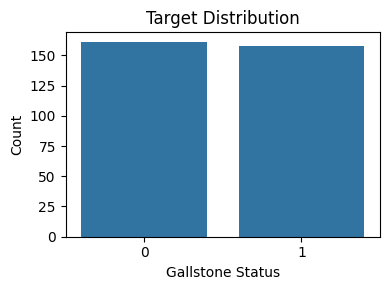

In [7]:
# Step 2 - Exploratory Data Analysis (EDA)
# 2.1 Target class distribution
plt.figure(figsize=(4, 3))
sns.countplot(x=y)
plt.title("Target Distribution")
plt.xlabel("Gallstone Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

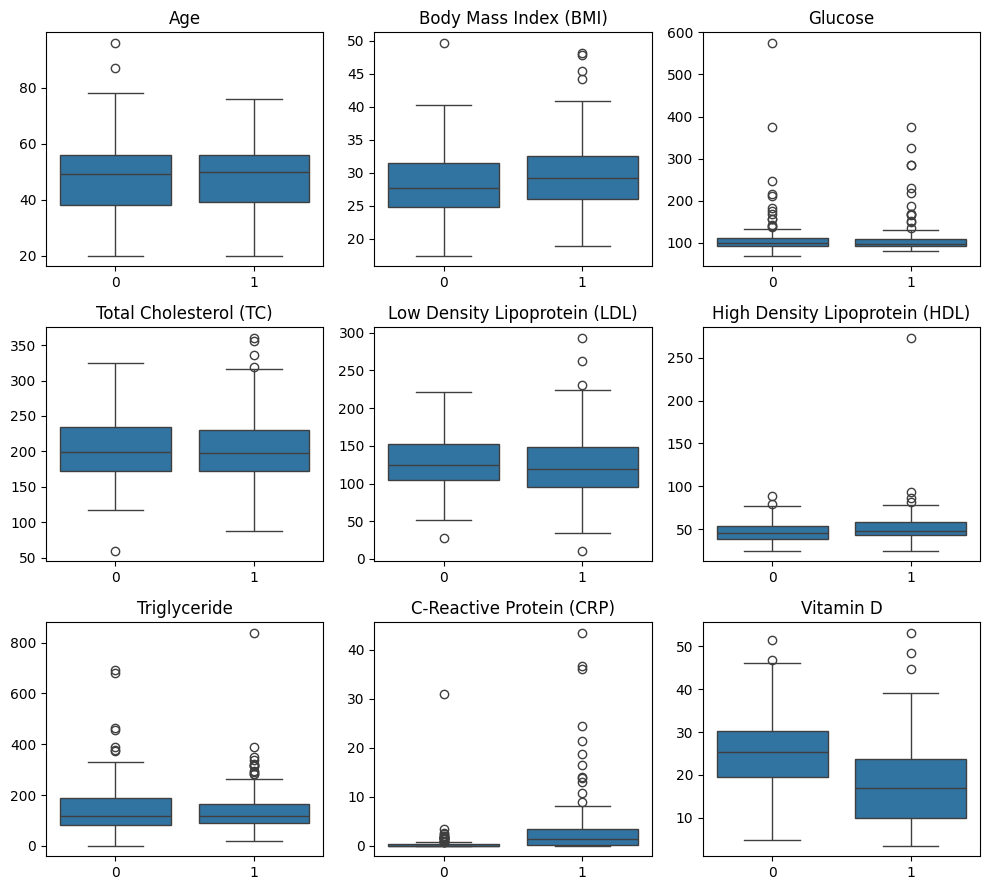

In [8]:
# 2.2 Key continuous features by outcome (boxplots)
key_feats = [
    "Age",
    "Body Mass Index (BMI)",
    "Glucose",
    "Total Cholesterol (TC)",
    "Low Density Lipoprotein (LDL)",
    "High Density Lipoprotein (HDL)",
    "Triglyceride",
    "C-Reactive Protein (CRP)",
    "Vitamin D",
]

fig, axes = plt.subplots(3, 3, figsize=(10, 9))
axes = axes.flatten()

for i, f in enumerate(key_feats):
    ax = axes[i]
    if f in df.columns:
        sns.boxplot(x=y, y=df[f], ax=ax)
        ax.set_title(f)
        ax.set_xlabel("")
        ax.set_ylabel("")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

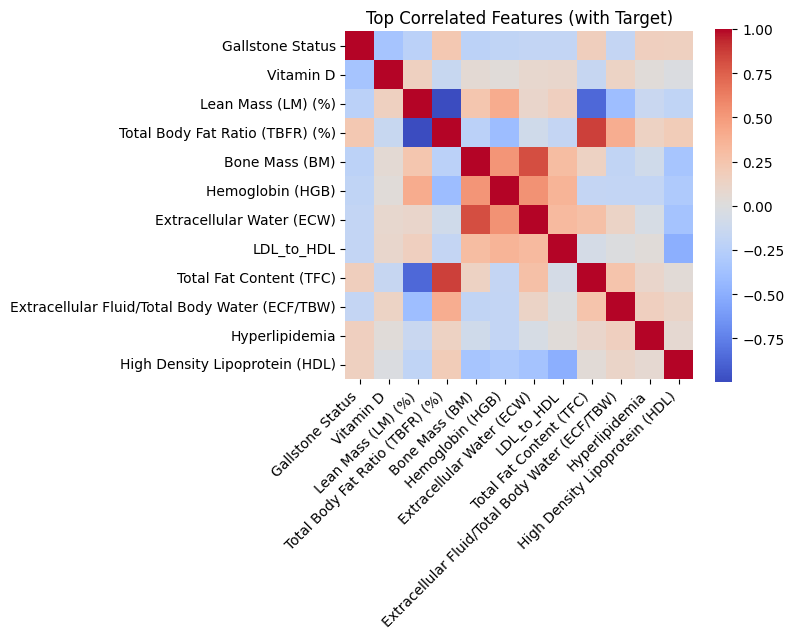

In [9]:
# 2.3 Correlation heatmap of top target-associated features
corr = pd.concat([X, y], axis=1).corr()
top_feats = corr[TARGET_COL].abs().sort_values(ascending=False).head(12).index

plt.figure(figsize=(8, 7))
sns.heatmap(
    corr.loc[top_feats, top_feats],
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Top Correlated Features (with Target)")
plt.tight_layout()
plt.show()

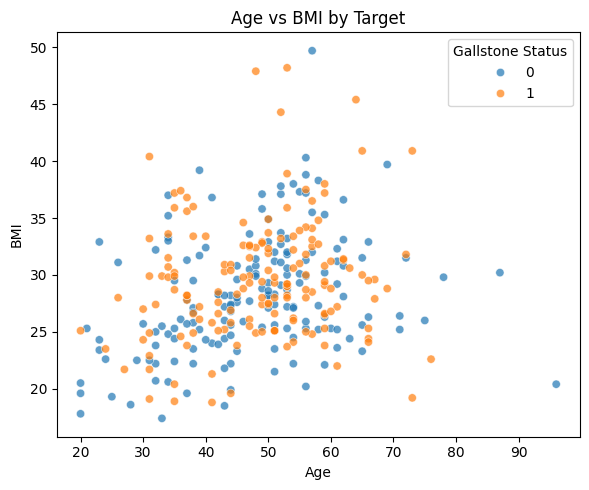

In [10]:
# 2.4 Age-BMI relationship by class
if "Age" in df.columns and "Body Mass Index (BMI)" in df.columns:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=df["Age"],
        y=df["Body Mass Index (BMI)"],
        hue=y,
        alpha=0.7
    )
    plt.title("Age vs BMI by Target")
    plt.xlabel("Age")
    plt.ylabel("BMI")
    plt.tight_layout()
    plt.show()

In [11]:
# 2.5 Univariate correlation with target
corr = pd.concat([X, y], axis=1).corr()[TARGET_COL].drop(TARGET_COL)
print('Top positive correlations with target:')
print(corr.sort_values(ascending=False).head(10))
print('Top negative correlations with target:')
print(corr.sort_values(ascending=True).head(10))

Top positive correlations with target:
Total Body Fat Ratio (TBFR) (%)    0.225470
Total Fat Content (TFC)            0.170158
Hyperlipidemia                     0.161901
High Density Lipoprotein (HDL)     0.158622
Gender                             0.153483
Visceral Fat Area (VFA)            0.140397
Body Mass Index (BMI)              0.121507
Diabetes Mellitus (DM)             0.104689
Hepatic Fat Accumulation (HFA)     0.090268
Age_x_BMI                          0.081374
Name: Gallstone Status, dtype: float64
Top negative correlations with target:
Vitamin D                                        -0.354873
Lean Mass (LM) (%)                               -0.225749
Bone Mass (BM)                                   -0.216570
Hemoglobin (HGB)                                 -0.196872
Extracellular Water (ECW)                        -0.178436
LDL_to_HDL                                       -0.177053
Extracellular Fluid/Total Body Water (ECF/TBW)   -0.169826
TC_to_HDL                     

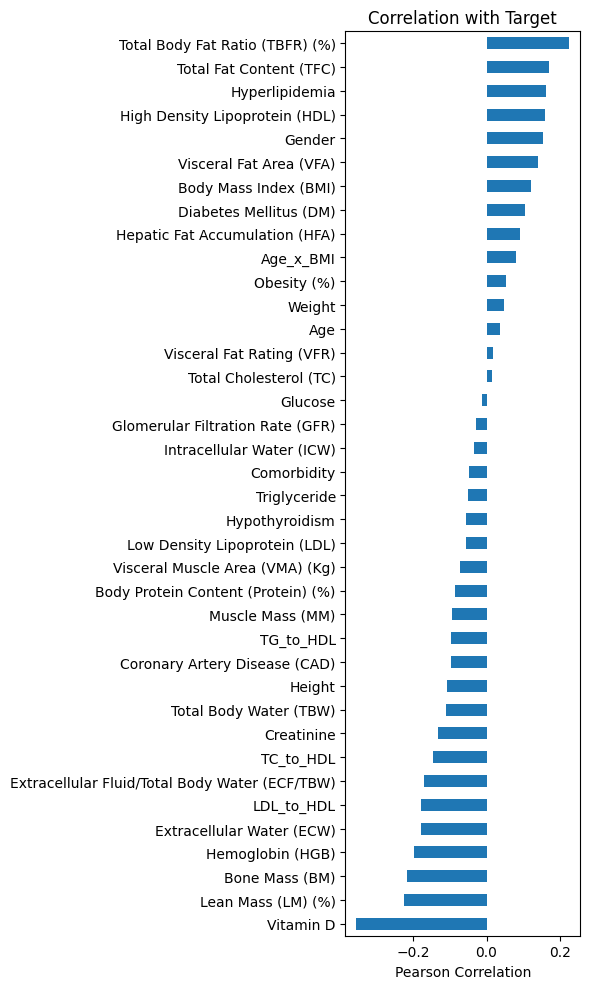

In [12]:
# 2.6 Horizontal bar chart of target correlations
corr_sorted = corr.sort_values()
plt.figure(figsize=(6, 10))
corr_sorted.plot(kind='barh')
plt.title('Correlation with Target')
plt.xlabel('Pearson Correlation')
plt.tight_layout()
plt.show()

In [13]:
# Step 3.1 Helper functions for single-track predictive modeling
def make_preprocessor(X_input, scale_numeric: bool):
    groups = get_col_groups(X_input)
    num_cols_local = groups['num_cols']
    cat_cols_local = groups['cat_cols']

    num_steps = [('imputer', SimpleImputer(strategy='median'))]
    if scale_numeric:
        num_steps.append(('scaler', StandardScaler()))

    transformers = []
    if num_cols_local:
        transformers.append(('num', Pipeline(steps=num_steps), num_cols_local))
    if cat_cols_local:
        transformers.append(('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))]), cat_cols_local))

    return ColumnTransformer(transformers=transformers, remainder='drop')


def build_models(X_input):
    pre_linear = make_preprocessor(X_input, scale_numeric=True)
    pre_tree = make_preprocessor(X_input, scale_numeric=False)
    return {
        'log_reg': Pipeline([
            ('pre', pre_linear),
            ('clf', LogisticRegression(max_iter=3000, solver='liblinear', random_state=RANDOM_STATE))
        ]),
        'random_forest': Pipeline([
            ('pre', pre_tree),
            ('clf', RandomForestClassifier(n_estimators=400, max_features='sqrt', random_state=RANDOM_STATE))
        ]),
        'hist_gb': Pipeline([
            ('pre', pre_tree),
            ('clf', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=200, random_state=RANDOM_STATE))
        ]),
        'lightgbm': Pipeline([
            ('pre', pre_tree),
            ('clf', LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE, verbose=-1, force_row_wise=True))
        ]),
        'xgboost': Pipeline([
            ('pre', pre_tree),
            ('clf', XGBClassifier(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                eval_metric='logloss'
            ))
        ])
    }


def build_param_grids():
    return {
        'log_reg': {'clf__C': [0.1, 1.0, 10.0], 'clf__penalty': ['l2']},
        'random_forest': {
            'clf__n_estimators': [300, 600],
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_leaf': [1, 3],
            'clf__max_features': ['sqrt', 0.5]
        },
        'hist_gb': {
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [None, 3],
            'clf__max_iter': [150, 250],
            'clf__l2_regularization': [0.0, 0.1]
        },
        'lightgbm': {
            'clf__n_estimators': [200, 400],
            'clf__learning_rate': [0.05, 0.1],
            'clf__num_leaves': [15, 31, 63]
        },
        'xgboost': {
            'clf__n_estimators': [200, 400],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 5],
            'clf__subsample': [0.8, 1.0],
            'clf__colsample_bytree': [0.8, 1.0]
        }
    }


def oof_predict_proba(estimator, X_input, y_input, cv):
    proba = cross_val_predict(estimator, X_input, y_input, cv=cv, method='predict_proba', n_jobs=-1)
    return proba[:, 1]


def best_f1_threshold(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    if thresholds.size == 0:
        return 0.5
    idx = int(np.nanargmax(f1))
    return float(thresholds[idx]) if idx < thresholds.size else 0.5


def compute_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        'roc_auc': float(roc_auc_score(y_true, y_prob)),
        'pr_auc': float(average_precision_score(y_true, y_prob)),
        'brier': float(brier_score_loss(y_true, y_prob)),
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
    }


def bootstrap_ci(y_true, y_prob, threshold, n_boot=300, seed=42):
    rng = np.random.default_rng(seed)
    rows = []
    for _ in range(n_boot):
        idx = rng.integers(0, len(y_true), len(y_true))
        yt = y_true[idx]
        yp = y_prob[idx]
        try:
            rows.append(compute_metrics(yt, yp, threshold))
        except Exception:
            continue
    if not rows:
        return {}
    dfm = pd.DataFrame(rows)
    out = {}
    for col in dfm.columns:
        out[col] = {
            'mean': float(dfm[col].mean()),
            'p025': float(dfm[col].quantile(0.025)),
            'p975': float(dfm[col].quantile(0.975)),
        }
    return out


def subgroup_report(df_input, y_true, y_prob, threshold, col, max_groups=6):
    if col not in df_input.columns:
        return
    vals = df_input[col].dropna()
    if vals.nunique() > max_groups:
        return
    print(f'\nSubgroup: {col}')
    for v in sorted(vals.unique()):
        mask = (df_input[col] == v).values
        if mask.sum() < 10:
            continue
        try:
            m = compute_metrics(y_true[mask], y_prob[mask], threshold)
            line = '  {}: n={} AUC={:.3f} F1={:.3f} R={:.3f}'.format(v, mask.sum(), m['roc_auc'], m['f1'], m['recall'])
        except Exception:
            line = f'  {v}: n={mask.sum()} (insufficient class variation for AUC)'
        print(line)

## Feature Selection Strategy

We compare multiple selection methods (MI, L1-based selection, RFECV) under a consistent cross-validation protocol on the development data.  
The final feature set is chosen by cross-validated predictive utility before train/validation/test model selection.  
This step controls dimensional noise and improves robustness for a small-to-moderate sample size.


In [14]:
# Step 3.2 Feature selection on private-clinic pool (used for final modeling)
np.random.seed(RANDOM_STATE)
X_base = X_pool.copy()

# Ensure numeric frame for MI/L1/RFECV
for c in X_base.select_dtypes(include=['object', 'category', 'bool']).columns:
    X_base[c] = X_base[c].astype('category').cat.codes

# MI
discrete_mask = [
    set(X_base[c].dropna().unique()).issubset({0, 1}) and X_base[c].dropna().nunique() > 0
    for c in X_base.columns
]
X_imputed = X_base.fillna(X_base.median(numeric_only=True))
mi = mutual_info_classif(X_imputed, y, discrete_features=discrete_mask, random_state=RANDOM_STATE)
mi_df = pd.DataFrame({'feature': X_base.columns, 'mi': mi}).sort_values('mi', ascending=False)
print('Top MI features:')
print(mi_df.head(15))

# L1
lasso_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=RANDOM_STATE))
])
lasso_pipe.fit(X_base, y)
coef = lasso_pipe.named_steps['clf'].coef_.ravel()
lasso_df = pd.DataFrame({'feature': X_base.columns, 'coef': coef}).sort_values('coef', key=np.abs, ascending=False)
selected_lasso = lasso_df[lasso_df['coef'] != 0]['feature'].tolist()
print('L1 selected features:')
print(selected_lasso)

# RFECV (PR-AUC aligned)
rfecv_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
X_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]).fit_transform(X_base)

rfecv = RFECV(
    estimator=LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE),
    step=1,
    cv=rfecv_cv,
    scoring='average_precision',
    n_jobs=-1
)
rfecv.fit(X_rf, y)
rfecv_features = X_base.columns[rfecv.support_].tolist()
print('RFECV selected features:', rfecv_features)
print('RFECV selected count:', len(rfecv_features))

# CV choose best MI k by PR-AUC
k_list = [5, 8, 10, 12, 15, 20]
k_list = [k for k in k_list if k <= X_base.shape[1]]
fs_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

mi_k_rows = []
for k in k_list:
    feats = mi_df.head(k)['feature'].tolist()
    X_sub = X_base[feats]
    pre = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), feats)
    ], remainder='drop')
    model = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE))])
    y_prob = oof_predict_proba(model, X_sub, y, fs_cv)
    thr = best_f1_threshold(y.values, y_prob)
    metrics = compute_metrics(y.values, y_prob, thr)
    mi_k_rows.append({'k': k, 'roc_auc': metrics['roc_auc'], 'pr_auc': metrics['pr_auc'], 'f1': metrics['f1']})

mi_k_df = pd.DataFrame(mi_k_rows).sort_values('pr_auc', ascending=False)
best_k = int(mi_k_df.iloc[0]['k'])
print('MI k selection (sorted by PR-AUC):')
print(mi_k_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))
print('Best k:', best_k)

feature_sets = {
    'mi_topk': mi_df.head(best_k)['feature'].tolist(),
    'lasso': selected_lasso,
    'rfecv': rfecv_features
}

# Compare methods by PR-AUC
fs_rows = []
for name, feats in feature_sets.items():
    if len(feats) == 0:
        continue
    X_sub = X_base[feats]
    pre = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), feats)
    ], remainder='drop')
    model = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE))])
    y_prob = oof_predict_proba(model, X_sub, y, fs_cv)
    thr = best_f1_threshold(y.values, y_prob)
    metrics = compute_metrics(y.values, y_prob, thr)
    fs_rows.append({'method': name, 'n_features': len(feats), 'roc_auc': metrics['roc_auc'], 'pr_auc': metrics['pr_auc'], 'f1': metrics['f1']})

fs_df = pd.DataFrame(fs_rows).sort_values('pr_auc', ascending=False).reset_index(drop=True)
print('Feature selection comparison (sorted by PR-AUC):')
print(fs_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

selected_features = feature_sets.get(fs_df.iloc[0]['method'], feature_sets['mi_topk'])
print('Selected feature method:', fs_df.iloc[0]['method'])
print('Selected feature count:', len(selected_features))

# Final modeling matrix after feature selection
X = X_base[selected_features].copy()

Top MI features:
                                           feature        mi
11                       Extracellular Water (ECW)  0.111844
13  Extracellular Fluid/Total Body Water (ECF/TBW)  0.077098
37                                       Age_x_BMI  0.075549
12                       Intracellular Water (ICW)  0.071759
26                          Total Cholesterol (TC)  0.070467
33                                       Vitamin D  0.067916
16              Body Protein Content (Protein) (%)  0.037965
24                  Hepatic Fat Accumulation (HFA)  0.030125
32                                Hemoglobin (HGB)  0.026488
17                       Visceral Fat Rating (VFR)  0.026184
29                                    Triglyceride  0.024463
18                                  Bone Mass (BM)  0.021258
22                         Visceral Fat Area (VFA)  0.020157
20                                     Obesity (%)  0.019629
5                                   Hyperlipidemia  0.017949
L1 sele

## Data Split

We create a stratified `train/validation/test` split (70%/10%/20%).
Feature selection is already finalized above; model training uses train only, model selection uses validation, and final reporting uses test.


In [15]:
# Train/Validation/Test split (70/10/20), stratified
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
# From remaining 80%, take 12.5% as validation => 10% absolute
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=RANDOM_STATE
)
X_trainval = pd.concat([X_train, X_val], axis=0).sort_index()
y_trainval = pd.concat([y_train, y_val], axis=0).sort_index()

print('Split sizes:')
print('  Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('Positive rate | Train={:.3f} Val={:.3f} Test={:.3f}'.format(y_train.mean(), y_val.mean(), y_test.mean()))

Split sizes:
  Train: (223, 28) Val: (32, 28) Test: (64, 28)
Positive rate | Train=0.493 Val=0.500 Test=0.500


## Baseline Modeling and Evaluation Protocol

Let

$$
\mathcal{D}=\{(x_i, y_i)\}_{i=1}^{N}, \quad y_i \in \{0,1\},
$$

where $y_i$ denotes gallstone status.

We benchmark five model families:
- Logistic Regression
- Random Forest
- HistGradientBoosting
- LightGBM
- XGBoost

Protocol in this notebook:
- Baseline CV is run on the **training split** only.
- Hyperparameter tuning is performed on **training split** (inner CV).
- Model and threshold are selected using the **validation split**.
- Final performance is reported once on the **hold-out test split**.

Primary ranking metric is PR-AUC (Average Precision):

$$
AP = \sum_{n}(R_n - R_{n-1})P_n
$$

Secondary metrics are reported for complementary evaluation (ROC-AUC, F1, precision, recall, Brier score).


## Step 3 - Baseline Models


In [16]:
# Baseline OOF benchmark on TRAIN split only
cv_train = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
models = build_models(X_train)

results = []
oof_by_model = {}
thr_by_model = {}

print(f'=== Train-split baseline modeling | n_features={X_train.shape[1]} ===')
for name, model in models.items():
    y_prob = oof_predict_proba(model, X_train, y_train, cv_train)
    thr = best_f1_threshold(y_train.values, y_prob)
    metrics = compute_metrics(y_train.values, y_prob, thr)
    metrics.update({'model': name, 'best_threshold': thr})
    results.append(metrics)
    oof_by_model[name] = y_prob
    thr_by_model[name] = thr
    print(f"- {name}: AUC={metrics['roc_auc']:.3f} PR-AUC={metrics['pr_auc']:.3f} F1={metrics['f1']:.3f} Thr={thr:.3f}")

baseline_df = pd.DataFrame(results).sort_values(by='pr_auc', ascending=False).reset_index(drop=True)
best_model_name = baseline_df.loc[0, 'model']
print('\nBaseline leaderboard on TRAIN OOF (sorted by PR-AUC):')
print(baseline_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))
print(f'\nBest baseline model: {best_model_name}')

=== Train-split baseline modeling | n_features=28 ===
- log_reg: AUC=0.850 PR-AUC=0.860 F1=0.804 Thr=0.515
- random_forest: AUC=0.782 PR-AUC=0.760 F1=0.753 Thr=0.445
- hist_gb: AUC=0.762 PR-AUC=0.761 F1=0.731 Thr=0.245
- lightgbm: AUC=0.780 PR-AUC=0.783 F1=0.740 Thr=0.470


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


- xgboost: AUC=0.773 PR-AUC=0.774 F1=0.746 Thr=0.273

Baseline leaderboard on TRAIN OOF (sorted by PR-AUC):
 roc_auc  pr_auc  brier  accuracy  precision  recall    f1         model  best_threshold
   0.850   0.860  0.154     0.816      0.848   0.764 0.804       log_reg           0.515
   0.780   0.783  0.208     0.744      0.743   0.736 0.740      lightgbm           0.470
   0.773   0.774  0.209     0.722      0.679   0.827 0.746       xgboost           0.273
   0.762   0.761  0.229     0.713      0.680   0.791 0.731       hist_gb           0.245
   0.782   0.760  0.194     0.735      0.698   0.818 0.753 random_forest           0.445

Best baseline model: log_reg


## Hyperparameter Tuning and Final Model Choice

After establishing train-split baselines, we perform hyperparameter optimization with inner cross-validation and PR-AUC as the primary scoring metric.  
Candidate models are compared on the validation split, and the operating threshold is selected on validation to match deployment goals.  
The selected configuration is then retrained on train+validation and evaluated once on the hold-out test set.


## Step 4 - Model Tuning


In [17]:
# Tune models on TRAIN, select by VALIDATION PR-AUC, report final TEST metrics
grids = build_param_grids()
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

models = build_models(X_train)
models_to_tune = ['log_reg', 'lightgbm', 'xgboost', 'random_forest', 'hist_gb']
n_iter_map = {
    'log_reg': 12,
    'lightgbm': 25,
    'xgboost': 25,
    'random_forest': 20,
    'hist_gb': 20,
}

candidate_rows = []
tuned_artifacts = {}

# Untuned logistic baseline on validation set
log_base = build_models(X_train)['log_reg'].fit(X_train, y_train)
val_prob_base = log_base.predict_proba(X_val)[:, 1]
log_thr_base = best_f1_threshold(y_val.values, val_prob_base)
log_metrics_base = compute_metrics(y_val.values, val_prob_base, log_thr_base)
candidate_rows.append({
    'model': 'log_reg_baseline',
    'roc_auc': log_metrics_base['roc_auc'],
    'pr_auc': log_metrics_base['pr_auc'],
    'f1': log_metrics_base['f1'],
    'precision': log_metrics_base['precision'],
    'recall': log_metrics_base['recall'],
    'accuracy': log_metrics_base['accuracy'],
    'brier': log_metrics_base['brier'],
    'best_threshold': log_thr_base,
})
print('Validation baseline log_reg:', log_metrics_base)

for name in models_to_tune:
    print(f'\n--- Tuning model: {name} ---')
    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=grids[name],
        n_iter=n_iter_map.get(name, 20),
        scoring='average_precision',
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    search.fit(X_train, y_train)

    best_est = search.best_estimator_
    val_prob = best_est.predict_proba(X_val)[:, 1]
    val_thr = best_f1_threshold(y_val.values, val_prob)
    val_metrics = compute_metrics(y_val.values, val_prob, val_thr)

    tuned_artifacts[name] = {
        'estimator': best_est,
        'params': search.best_params_,
        'val_threshold': val_thr,
        'val_metrics': val_metrics,
    }

    candidate_rows.append({
        'model': name,
        'roc_auc': val_metrics['roc_auc'],
        'pr_auc': val_metrics['pr_auc'],
        'f1': val_metrics['f1'],
        'precision': val_metrics['precision'],
        'recall': val_metrics['recall'],
        'accuracy': val_metrics['accuracy'],
        'brier': val_metrics['brier'],
        'best_threshold': val_thr,
    })

    print('Validation metrics:', val_metrics)
    print('Best params:', search.best_params_)

candidate_df = pd.DataFrame(candidate_rows).sort_values('pr_auc', ascending=False).reset_index(drop=True)
print('\nCandidate leaderboard on VALIDATION (PR-AUC):')
print(candidate_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

best_model_name = candidate_df.loc[0, 'model']
if best_model_name == 'log_reg_baseline':
    final_model = build_models(X_trainval)['log_reg']
    final_model.fit(X_trainval, y_trainval)
    best_thr = float(log_thr_base)
    best_params = {}
    val_metrics_selected = log_metrics_base
else:
    final_model = tuned_artifacts[best_model_name]['estimator']
    final_model.fit(X_trainval, y_trainval)
    best_thr = float(tuned_artifacts[best_model_name]['val_threshold'])
    best_params = tuned_artifacts[best_model_name]['params']
    val_metrics_selected = tuned_artifacts[best_model_name]['val_metrics']

# Final hold-out test evaluation
test_prob = final_model.predict_proba(X_test)[:, 1]
test_metrics = compute_metrics(y_test.values, test_prob, best_thr)

oof_prob = test_prob  # keep downstream cell compatibility
y_true = y_test.values
X_eval = X_test.copy()
y_eval = y_test.copy()
df_eval = df.loc[X_eval.index].copy()

baseline_df = candidate_df.copy()
print(f'\nSelected final model: {best_model_name}')
print('Selected threshold (from validation):', round(best_thr, 4))
print('Validation metrics (selected model):', val_metrics_selected)
print('Hold-out TEST metrics:', test_metrics)
if best_params:
    print('Best params:', best_params)

Validation baseline log_reg: {'roc_auc': 0.765625, 'pr_auc': 0.8205431312968077, 'brier': 0.20432197510390415, 'accuracy': 0.625, 'precision': 0.5714285714285714, 'recall': 1.0, 'f1': 0.7272727272727273}

--- Tuning model: log_reg ---


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=12. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Validation metrics: {'roc_auc': 0.7890625, 'pr_auc': 0.8399488237323915, 'brier': 0.19745656145343154, 'accuracy': 0.625, 'precision': 0.5714285714285714, 'recall': 1.0, 'f1': 0.7272727272727273}
Best params: {'clf__penalty': 'l2', 'clf__C': 10.0}

--- Tuning model: lightgbm ---


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=25. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Validation metrics: {'roc_auc': 0.78515625, 'pr_auc': 0.750833263958264, 'brier': 0.1963737438768005, 'accuracy': 0.75, 'precision': 0.6818181818181818, 'recall': 0.9375, 'f1': 0.7894736842105263}
Best params: {'clf__num_leaves': 15, 'clf__n_estimators': 400, 'clf__learning_rate': 0.05}

--- Tuning model: xgboost ---
Validation metrics: {'roc_auc': 0.7421875, 'pr_auc': 0.7314284120008518, 'brier': 0.21126408569248528, 'accuracy': 0.75, 'precision': 0.6666666666666666, 'recall': 1.0, 'f1': 0.8}
Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1.0}

--- Tuning model: random_forest ---
Validation metrics: {'roc_auc': 0.75390625, 'pr_auc': 0.7367257666188587, 'brier': 0.20336859728703421, 'accuracy': 0.75, 'precision': 0.6818181818181818, 'recall': 0.9375, 'f1': 0.7894736842105263}
Best params: {'clf__n_estimators': 600, 'clf__min_samples_leaf': 3, 'clf__max_features': 'sqrt', 'clf__max_depth': 5}

--- T

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Validation metrics: {'roc_auc': 0.78125, 'pr_auc': 0.7887978280777194, 'brier': 0.20071954830359492, 'accuracy': 0.71875, 'precision': 0.64, 'recall': 1.0, 'f1': 0.7804878048780488}
Best params: {'clf__max_iter': 150, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__l2_regularization': 0.0}

Candidate leaderboard on VALIDATION (PR-AUC):
           model  roc_auc  pr_auc    f1  precision  recall  accuracy  brier  best_threshold
         log_reg    0.789   0.840 0.727      0.571   1.000     0.625  0.197           0.105
log_reg_baseline    0.766   0.821 0.727      0.571   1.000     0.625  0.204           0.142
         hist_gb    0.781   0.789 0.780      0.640   1.000     0.719  0.201           0.133
        lightgbm    0.785   0.751 0.789      0.682   0.938     0.750  0.196           0.449
   random_forest    0.754   0.737 0.789      0.682   0.938     0.750  0.203           0.437
         xgboost    0.742   0.731 0.800      0.667   1.000     0.750  0.211           0.281

Selected fi

## Step 5 - Validation/Test Diagnostics


In [18]:
# Compare calibration methods on VALIDATION split
base_key = 'log_reg' if best_model_name == 'log_reg_baseline' else best_model_name
cal_base = build_models(X_train)[base_key]
if best_model_name != 'log_reg_baseline' and 'best_params' in locals() and best_params:
    cal_base.set_params(**best_params)

for method in ['sigmoid', 'isotonic']:
    cal = CalibratedClassifierCV(cal_base, method=method, cv=3)
    cal.fit(X_train, y_train)
    cal_prob = cal.predict_proba(X_val)[:, 1]
    thr = best_f1_threshold(y_val.values, cal_prob)
    metrics = compute_metrics(y_val.values, cal_prob, thr)
    print(f'Calibrated ({method}) validation metrics:', metrics)

Calibrated (sigmoid) validation metrics: {'roc_auc': 0.7890625, 'pr_auc': 0.844490815556992, 'brier': 0.1809138144232218, 'accuracy': 0.625, 'precision': 0.5714285714285714, 'recall': 1.0, 'f1': 0.7272727272727273}
Calibrated (isotonic) validation metrics: {'roc_auc': 0.796875, 'pr_auc': 0.8349198309860075, 'brier': 0.18981787154284774, 'accuracy': 0.78125, 'precision': 0.8461538461538461, 'recall': 0.6875, 'f1': 0.7586206896551724}


In [19]:
oof_pred = (oof_prob >= best_thr).astype(int)
print('Confusion matrix (TEST):')
print(confusion_matrix(y_true, oof_pred))
print('Metrics (TEST):')
print(compute_metrics(y_true, oof_prob, best_thr))

Confusion matrix (TEST):
[[10 22]
 [ 3 29]]
Metrics (TEST):
{'roc_auc': 0.8134765625, 'pr_auc': 0.8475044782878258, 'brier': 0.18695016205156154, 'accuracy': 0.609375, 'precision': 0.5686274509803921, 'recall': 0.90625, 'f1': 0.6987951807228916}


## Calibration and Probability Reliability

Strong discrimination alone is not sufficient for deployment in a triage workflow.  
In this setting, the predicted score is used as an estimated risk probability, so we need to verify that predicted risk levels are well aligned with observed event rates.

Calibration analysis directly addresses this requirement, for example, patients predicted at 30% risk are actually close to a 30% observed outcome rate.  
This is especially important when referral thresholds are operationally defined, since poor calibration can systematically over-refer or under-refer patients even when ranking performance looks good.

For that reason, calibration is treated as a deployment-readiness check rather than an optional diagnostic plot.


## Step 6 - Calibration


In [20]:
prob_true, prob_pred = calibration_curve(y_true, oof_prob, n_bins=10, strategy='quantile')
print('Calibration bins on TEST (pred_mean -> true_rate):')
for p_pred, p_true in zip(prob_pred, prob_true):
    print('{:.3f} -> {:.3f}'.format(p_pred, p_true))

Calibration bins on TEST (pred_mean -> true_rate):
0.020 -> 0.143
0.079 -> 0.333
0.177 -> 0.167
0.256 -> 0.143
0.389 -> 0.500
0.531 -> 0.667
0.716 -> 0.571
0.888 -> 0.500
0.971 -> 1.000
0.998 -> 1.000


## Step 7 - Uncertainty (Bootstrap)


In [21]:
ci = bootstrap_ci(y_true, oof_prob, best_thr, n_boot=N_BOOT, seed=RANDOM_STATE)
print('Bootstrap CI on TEST (mean, 2.5%, 97.5%):')
for k, v in ci.items():
    print('{}: mean={:.3f} [{:.3f}, {:.3f}]'.format(k, v['mean'], v['p025'], v['p975']))

Bootstrap CI on TEST (mean, 2.5%, 97.5%):
roc_auc: mean=0.814 [0.705, 0.909]
pr_auc: mean=0.850 [0.735, 0.934]
brier: mean=0.186 [0.122, 0.250]
accuracy: mean=0.609 [0.492, 0.734]
precision: mean=0.568 [0.439, 0.707]
recall: mean=0.904 [0.794, 0.973]
f1: mean=0.695 [0.585, 0.802]


## Step 8 - Subgroup Performance


In [22]:
if 'Gender' in df_eval.columns:
    subgroup_report(df_eval, y_true, oof_prob, best_thr, 'Gender')
if 'Age' in df_eval.columns:
    bins = [0, 40, 50, 60, 200]
    labels = ['<=40','41-50','51-60','>60']
    df_eval['Age_bin'] = pd.cut(df_eval['Age'], bins=bins, labels=labels)
    subgroup_report(df_eval, y_true, oof_prob, best_thr, 'Age_bin')


Subgroup: Gender
  0: n=29 AUC=0.774 F1=0.667 R=0.846
  1: n=35 AUC=0.849 F1=0.720 R=0.947

Subgroup: Age_bin
  41-50: n=21 AUC=0.745 F1=0.824 R=1.000
  51-60: n=18 AUC=0.762 F1=0.600 R=0.750
  <=40: n=15 AUC=0.804 F1=0.632 R=0.857
  >60: n=10 AUC=0.952 F1=0.600 R=1.000


## Model Interpretability

To make the model clinically usable, we include both global and local interpretability analyses.  
At the global level, SHAP and permutation importance are used to identify which features consistently drive risk predictions across the full cohort.  
At the local level, case-based SHAP explanations are used to show why a specific patient is flagged as high risk, which supports chart review and clinician communication.

From a modeling perspective, these tools also serve as quality checks: they help detect unstable feature effects, potential leakage signals, or counterintuitive model behavior.  
If interpretation patterns conflict with clinical expectation, the feature set, preprocessing, or threshold policy should be revisited before deployment.

Importantly, these interpretation outputs describe **how the trained model makes predictions** under the observed data distribution.  
They do **not** establish causal effects and should not be used as standalone evidence for intervention decisions.


## Step 9 - Feature Importance


In [23]:
# Permutation importance on hold-out TEST set
perm = permutation_importance(final_model, X_eval, y_eval, n_repeats=20, random_state=RANDOM_STATE, scoring='average_precision', n_jobs=-1)
fi = pd.DataFrame({
    'feature': X_eval.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std,
}).sort_values(by='importance_mean', ascending=False)
print('Top features on TEST:')
print(fi.head(TOP_N_FEATURES))

Top features on TEST:
                            feature  importance_mean  importance_std
2         Intracellular Water (ICW)         0.170478        0.043884
0                    Bone Mass (BM)         0.132949        0.034123
25        Extracellular Water (ECW)         0.130702        0.026148
6                    Hyperlipidemia         0.090406        0.040583
14           Total Body Water (TBW)         0.080712        0.029558
4                         Vitamin D         0.066680        0.030402
22               Lean Mass (LM) (%)         0.063374        0.037162
3                            Gender         0.058099        0.015007
1   Total Body Fat Ratio (TBFR) (%)         0.053805        0.033451
11          Total Fat Content (TFC)         0.048458        0.019228
7                  Hemoglobin (HGB)         0.041490        0.017422
9                  Muscle Mass (MM)         0.026860        0.014396
10                           Height         0.020870        0.008813
17          

In [24]:
# Model leaderboard summary (validation)
cols = ['model', 'roc_auc', 'pr_auc', 'f1', 'precision', 'recall', 'accuracy', 'brier', 'best_threshold']
summary_df = baseline_df[cols].copy()
best_idx = summary_df['pr_auc'].idxmax()
summary_df['best'] = ''
summary_df.loc[best_idx, 'best'] = '<-- best'
print('Model Leaderboard (Validation)')
print(summary_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

Model Leaderboard (Validation)
           model  roc_auc  pr_auc    f1  precision  recall  accuracy  brier  best_threshold     best
         log_reg    0.789   0.840 0.727      0.571   1.000     0.625  0.197           0.105 <-- best
log_reg_baseline    0.766   0.821 0.727      0.571   1.000     0.625  0.204           0.142         
         hist_gb    0.781   0.789 0.780      0.640   1.000     0.719  0.201           0.133         
        lightgbm    0.785   0.751 0.789      0.682   0.938     0.750  0.196           0.449         
   random_forest    0.754   0.737 0.789      0.682   0.938     0.750  0.203           0.437         
         xgboost    0.742   0.731 0.800      0.667   1.000     0.750  0.211           0.281         


## Step 10 - Visual Validation


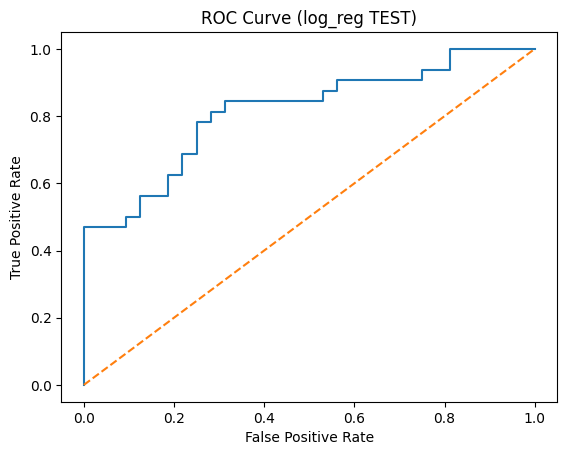

In [25]:
# ROC (selected model on TEST)
fpr, tpr, _ = roc_curve(y_true, oof_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'ROC Curve ({best_model_name} TEST)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

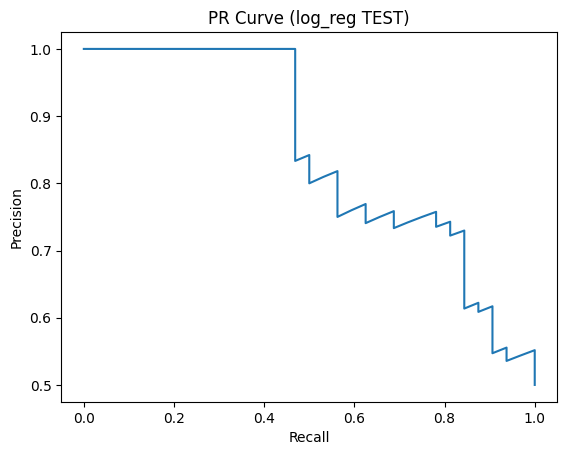

In [26]:
# PR curve (selected model on TEST)
precision, recall, _ = precision_recall_curve(y_true, oof_prob)
plt.figure()
plt.plot(recall, precision)
plt.title(f'PR Curve ({best_model_name} TEST)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [27]:
# Risk tier assignment based on selected OOF threshold
thr = best_thr

# Assign risk tiers from OOF probabilities
risk_tier = np.where(oof_prob >= thr, "High Risk", "Low Risk")

risk_df = pd.DataFrame({
    "Probability": oof_prob,
    "Risk Tier": risk_tier,
    "True Label": y_true
})

print("Risk Tier Distribution")
print(risk_df["Risk Tier"].value_counts())

print("\nObserved Gallstone Rate by Tier")
print(risk_df.groupby("Risk Tier")["True Label"].mean())

Risk Tier Distribution
Risk Tier
High Risk    51
Low Risk     13
Name: count, dtype: int64

Observed Gallstone Rate by Tier
Risk Tier
High Risk    0.568627
Low Risk     0.230769
Name: True Label, dtype: float64


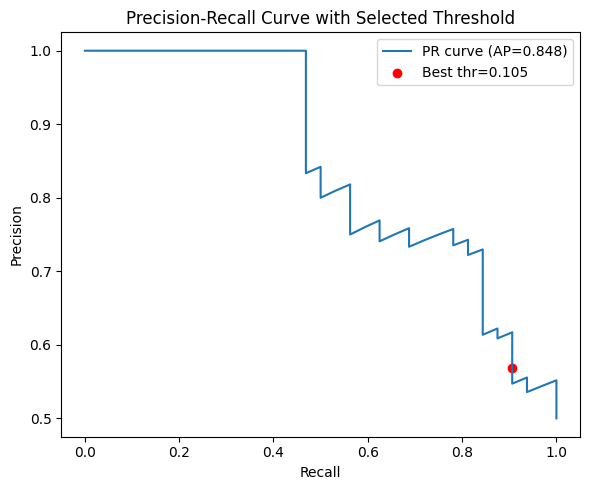

In [28]:
precision, recall, thresholds = precision_recall_curve(y_true, oof_prob)
pr_auc = average_precision_score(y_true, oof_prob)

y_hat = (oof_prob >= best_thr).astype(int)
p_thr = y_true[y_hat == 1].mean() if (y_hat == 1).any() else 0
r_thr = ((y_hat == 1) & (y_true == 1)).sum() / max((y_true == 1).sum(), 1)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR curve (AP={pr_auc:.3f})")
plt.scatter([r_thr], [p_thr], color="red", label=f"Best thr={best_thr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Selected Threshold")
plt.legend()
plt.tight_layout()
plt.show()

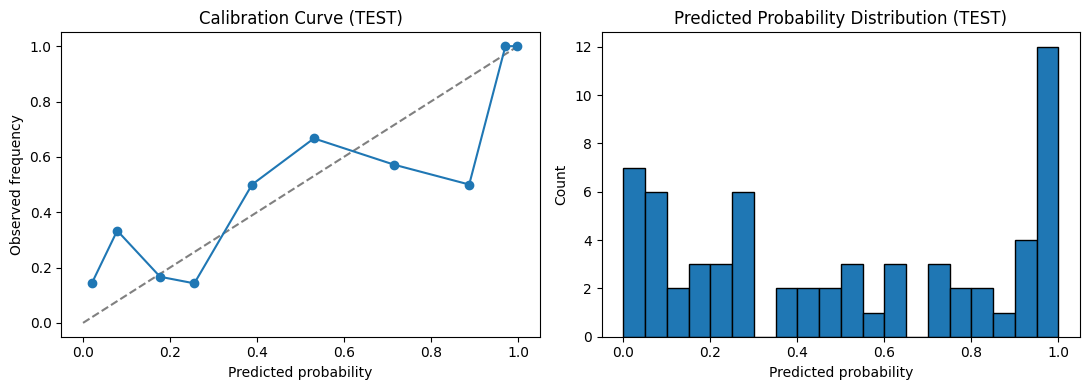

In [29]:
prob_true, prob_pred = calibration_curve(y_true, oof_prob, n_bins=10, strategy="quantile")

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# reliability curve
ax[0].plot([0, 1], [0, 1], "--", color="gray")
ax[0].plot(prob_pred, prob_true, marker="o")
ax[0].set_xlabel("Predicted probability")
ax[0].set_ylabel("Observed frequency")
ax[0].set_title("Calibration Curve (TEST)")

# probability histogram
ax[1].hist(oof_prob, bins=20, edgecolor="black")
ax[1].set_xlabel("Predicted probability")
ax[1].set_ylabel("Count")
ax[1].set_title("Predicted Probability Distribution (TEST)")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/tmp/ipython-input-373/3568288203.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_trans_df, feature_names=feature_names_clean, max_display=15)


SHAP NaN ratio: 0.0
SHAP abs mean: 0.7858912058886441


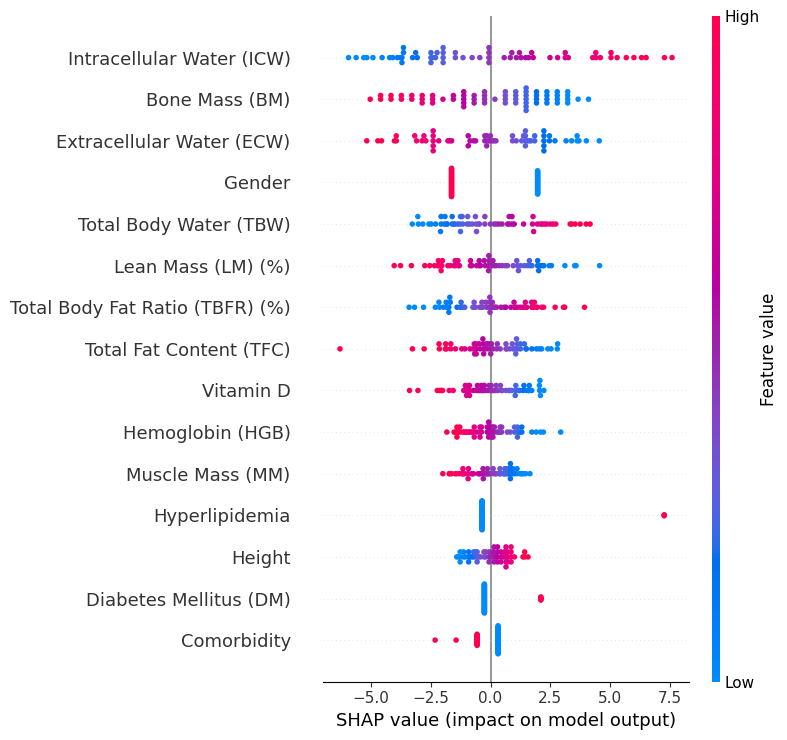

In [30]:
# SHAP pipeline for global and local interpretability on TEST split
pre = final_model.named_steps["pre"]
clf = final_model.named_steps["clf"]

X_trans = pre.transform(X_eval)
feature_names_raw = list(pre.get_feature_names_out())

if sp.issparse(X_trans):
    X_dense = X_trans.toarray()
else:
    X_dense = np.asarray(X_trans)

X_trans_df = pd.DataFrame(X_dense, columns=feature_names_raw)
X_trans_df = X_trans_df.replace([np.inf, -np.inf], np.nan).fillna(0)

feature_names_clean = [n.replace("num__", "").replace("cat__", "") for n in feature_names_raw]

if best_model_name in ["log_reg", "log_reg_baseline"]:
    explainer = shap.LinearExplainer(clf, X_trans_df, feature_perturbation="interventional")
    vals = explainer.shap_values(X_trans_df)
else:
    explainer = shap.TreeExplainer(clf)
    sv = explainer.shap_values(X_trans_df)
    vals = sv[1] if isinstance(sv, list) else sv

print("SHAP NaN ratio:", np.isnan(vals).mean())
print("SHAP abs mean:", np.nanmean(np.abs(vals)))

shap.summary_plot(vals, X_trans_df, feature_names=feature_names_clean, max_display=15)

Case Study Patient (test row position): 54
Predicted Probability: 1.000


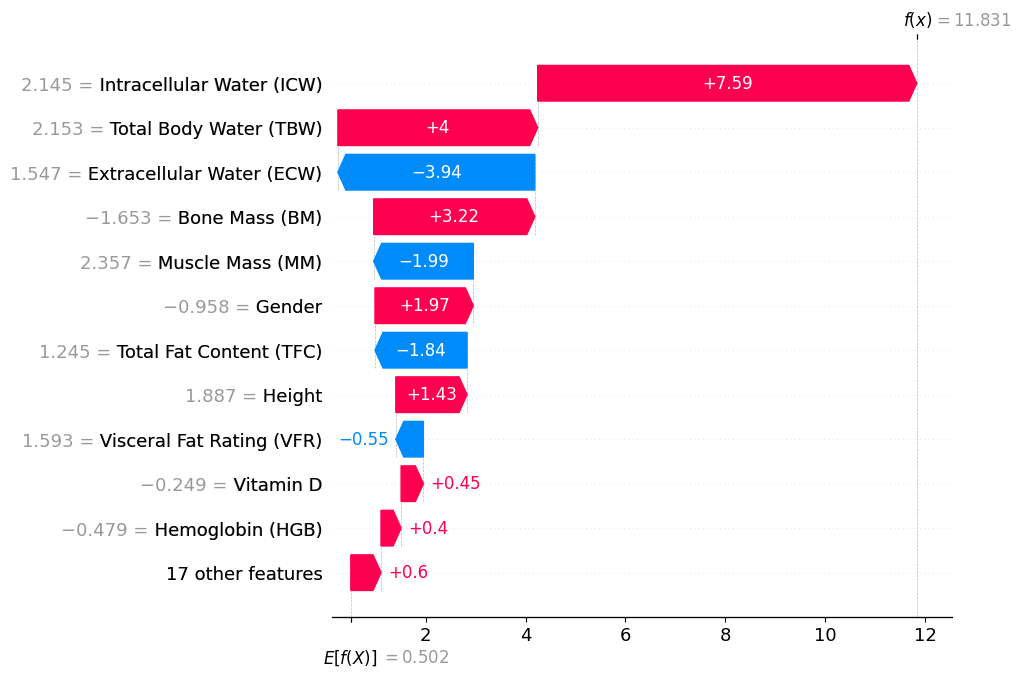

In [31]:
# Case study: highest predicted-risk sample on TEST split
probs = final_model.predict_proba(X_eval)[:, 1]
idx = int(np.argmax(probs))

print(f"Case Study Patient (test row position): {idx}")
print(f"Predicted Probability: {probs[idx]:.3f}")

waterfall_exp = shap.Explanation(
    values=vals[idx],
    base_values=float(np.mean(probs)),
    data=X_trans_df.iloc[idx].values,
    feature_names=feature_names_clean
)

shap.plots.waterfall(waterfall_exp, max_display=12)

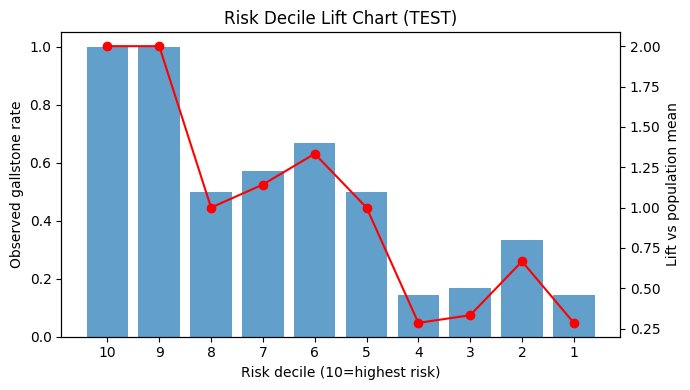

In [32]:
eval_df = pd.DataFrame({"y": y_true, "score": oof_prob})
eval_df["decile"] = pd.qcut(eval_df["score"], 10, labels=False, duplicates="drop") + 1
dec = eval_df.groupby("decile", as_index=False).agg(
    event_rate=("y", "mean"),
    n=("y", "size")
).sort_values("decile", ascending=False)

base_rate = eval_df["y"].mean()
dec["lift"] = dec["event_rate"] / base_rate

fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.bar(dec["decile"].astype(str), dec["event_rate"], alpha=0.7, label="Event rate")
ax1.set_xlabel("Risk decile (10=highest risk)")
ax1.set_ylabel("Observed gallstone rate")

ax2 = ax1.twinx()
ax2.plot(dec["decile"].astype(str), dec["lift"], color="red", marker="o", label="Lift")
ax2.set_ylabel("Lift vs population mean")

plt.title("Risk Decile Lift Chart (TEST)")
plt.tight_layout()
plt.show()

In [39]:
# Final hold-out TEST performance report
print("Selected final model:", best_model_name)
print("Selected threshold (from validation):", round(best_thr, 4))

# test probabilities are stored in oof_prob in current notebook logic
test_prob = oof_prob
test_pred = (test_prob >= best_thr).astype(int)

test_metrics = compute_metrics(y_test.values, test_prob, best_thr)
print("\n=== Final TEST Metrics ===")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Confusion Matrix (TEST) ===")
cm = confusion_matrix(y_test.values, test_pred)
print(cm)

tn, fp, fn, tp = cm.ravel()
print("\n=== TEST Classification Summary ===")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Sensitivity/Recall: {tp/(tp+fn):.4f}" if (tp+fn)>0 else "Sensitivity/Recall: NA")
print(f"Specificity: {tn/(tn+fp):.4f}" if (tn+fp)>0 else "Specificity: NA")
print(f"PPV/Precision: {tp/(tp+fp):.4f}" if (tp+fp)>0 else "PPV/Precision: NA")
print(f"NPV: {tn/(tn+fn):.4f}" if (tn+fn)>0 else "NPV: NA")

Selected final model: log_reg
Selected threshold (from validation): 0.105

=== Final TEST Metrics ===
roc_auc: 0.8135
pr_auc: 0.8475
brier: 0.1870
accuracy: 0.6094
precision: 0.5686
recall: 0.9062
f1: 0.6988

=== Confusion Matrix (TEST) ===
[[10 22]
 [ 3 29]]

=== TEST Classification Summary ===
TN=10, FP=22, FN=3, TP=29
Sensitivity/Recall: 0.9062
Specificity: 0.3125
PPV/Precision: 0.5686
NPV: 0.7692


## Overall Summary, Clinical Implications, and Limitations

### Study Summary
In this project, we built a non-imaging gallstone risk prediction pipeline for routine checkup settings using demographic, body-composition, and laboratory variables.  
The workflow was structured as leakage control, feature engineering, feature selection (MI/L1/RFECV), train/validation/test split, tuning, threshold optimization, and calibration/policy analysis.  
The final model showed stable validation performance and was finally assessed on a hold-out test set, supporting use as a pre-screening support tool in private-clinic workflows.

### Practical Implications
The model supports early risk stratification before imaging, helping prioritize follow-up ultrasound when capacity is limited.  
Because outputs are probabilistic, thresholds can be adapted to operational priorities (higher recall vs fewer false positives).

### Interpretability
SHAP and permutation importance indicate that metabolic and body-composition variables are major predictive drivers.  
These are predictive explanations and should not be interpreted as direct causal evidence.

### Causal Sensitivity (Appendix)
Supplementary AIPW/IPW/OR analysis suggests positive associations for some binary exposures (e.g., hyperlipidemia, diabetes mellitus).  
However, rare-treatment prevalence and weak overlap require cautious interpretation; findings are hypothesis-generating, not confirmatory.

### Limitations
1. Single-center dataset and modest sample size limit external validity.  
2. Observational retrospective design leaves residual confounding risk.  
3. Performance and estimated effects may shift across institutions and lab protocols.  
4. Some causal sensitivity estimates are unstable under weak overlap.

### Future Work
Future work includes multi-center external validation, prospective evaluation, subgroup fairness checks, and decision-curve/net-benefit analysis.


## Appendix: Causal Inference (Sensitivity Analysis)

This section estimates treatment effects from observational data using Naive, IPW, Outcome Regression, and cross-fitted AIPW.
Results are sensitivity evidence under no-unmeasured-confounding and overlap assumptions, not definitive causal proof.
We keep leakage variables excluded to match the routine checkup use case.


In [33]:
# Optional: run once if packages are missing
#%pip install -q econml dowhy causalml

In [34]:
# Build causal dataset (independent from modeling feature-selection state)
causal_df = df.copy()

# keep routine-checkup logic: remove known leakage/post-diagnostic variables
leakage_cols = [c for c in [
    'C-Reactive Protein (CRP)',
    'Aspartat Aminotransferaz (AST)',
    'Alanin Aminotransferaz (ALT)',
    'Alkaline Phosphatase (ALP)',
    'AST_to_ALT'
] if c in causal_df.columns]

causal_df = causal_df.drop(columns=leakage_cols, errors='ignore')

OUTCOME_COL = TARGET_COL
causal_df[OUTCOME_COL] = causal_df[OUTCOME_COL].astype(int)

# binary candidate treatments
candidate_treatments = []
for c in causal_df.columns:
    if c == OUTCOME_COL:
        continue
    vals = set(causal_df[c].dropna().unique())
    if vals.issubset({0, 1}) and causal_df[c].nunique(dropna=True) == 2:
        candidate_treatments.append(c)

print("Causal rows:", len(causal_df))
print("Leakage dropped:", leakage_cols)
print("Binary treatments:", candidate_treatments)

for t in candidate_treatments:
    vc = causal_df[t].value_counts(dropna=False)
    print(f"{t}: treated={int(vc.get(1, 0))}, control={int(vc.get(0, 0))}")

Causal rows: 319
Leakage dropped: ['C-Reactive Protein (CRP)', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'AST_to_ALT']
Binary treatments: ['Gender', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)']
Gender: treated=157, control=162
Coronary Artery Disease (CAD): treated=12, control=307
Hypothyroidism: treated=9, control=310
Hyperlipidemia: treated=8, control=311
Diabetes Mellitus (DM): treated=43, control=276


In [35]:
# Helper models
def _build_binary_clf():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=4000, solver='liblinear', random_state=RANDOM_STATE))
    ])

def _fit_or_constant(X_tr, y_tr):
    if len(y_tr) == 0:
        return None, 0.5
    if len(np.unique(y_tr)) < 2:
        return None, float(np.mean(y_tr))
    m = _build_binary_clf()
    m.fit(X_tr, y_tr)
    return m, None

def _predict_or_constant(model, const_val, X_te):
    if model is None:
        return np.full(X_te.shape[0], const_val, dtype=float)
    return model.predict_proba(X_te)[:, 1]

def estimate_ate_binary(df_in, treatment, outcome_col, n_splits=5, seed=16, clip=0.02):
    # build arrays only (avoid pandas index bugs)
    cols = [treatment, outcome_col] + [c for c in df_in.columns if c not in [treatment, outcome_col]]
    tmp = df_in[cols].dropna().copy()
    tmp = tmp[tmp[treatment].isin([0, 1])]
    tmp = tmp[tmp[outcome_col].isin([0, 1])]

    T = tmp[treatment].astype(int).to_numpy()
    Y = tmp[outcome_col].astype(int).to_numpy()
    W_df = pd.get_dummies(tmp.drop(columns=[treatment, outcome_col]), drop_first=True)
    W = W_df.to_numpy(dtype=float)

    n = len(tmp)
    n_t = int(T.sum())
    n_c = int(n - n_t)
    max_splits = int(min(n_splits, n_t, n_c))
    if max_splits < 2:
        raise ValueError(f"Not enough treated/control for CV: treated={n_t}, control={n_c}")

    ate_naive = float(Y[T == 1].mean() - Y[T == 0].mean())

    p = np.zeros(n, dtype=float)
    mu1 = np.zeros(n, dtype=float)
    mu0 = np.zeros(n, dtype=float)

    skf = StratifiedKFold(n_splits=max_splits, shuffle=True, random_state=seed)
    for tr, va in skf.split(W, T):
        p_model = _build_binary_clf()
        p_model.fit(W[tr], T[tr])
        p[va] = p_model.predict_proba(W[va])[:, 1]

        m1, c1 = _fit_or_constant(W[tr][T[tr] == 1], Y[tr][T[tr] == 1])
        m0, c0 = _fit_or_constant(W[tr][T[tr] == 0], Y[tr][T[tr] == 0])

        mu1[va] = _predict_or_constant(m1, c1, W[va])
        mu0[va] = _predict_or_constant(m0, c0, W[va])

    p = np.clip(p, clip, 1 - clip)

    # IPW
    phi_ipw = T * Y / p - (1 - T) * Y / (1 - p)
    ate_ipw = float(phi_ipw.mean())
    se_ipw = float(phi_ipw.std(ddof=1) / np.sqrt(n))

    # Outcome regression
    phi_or = mu1 - mu0
    ate_or = float(phi_or.mean())
    se_or = float(phi_or.std(ddof=1) / np.sqrt(n))

    # AIPW (doubly robust)
    psi = (mu1 - mu0) + T * (Y - mu1) / p - (1 - T) * (Y - mu0) / (1 - p)
    ate_aipw = float(psi.mean())
    se_aipw = float(psi.std(ddof=1) / np.sqrt(n))

    z = 1.96
    return {
        'treatment': treatment,
        'n': n,
        'treated_n': n_t,
        'control_n': n_c,
        'cv_splits_used': max_splits,
        'ate_naive': ate_naive,
        'ate_ipw': ate_ipw,
        'ipw_ci95': (ate_ipw - z * se_ipw, ate_ipw + z * se_ipw),
        'ate_or': ate_or,
        'or_ci95': (ate_or - z * se_or, ate_or + z * se_or),
        'ate_aipw': ate_aipw,
        'aipw_ci95': (ate_aipw - z * se_aipw, ate_aipw + z * se_aipw),
        'propensity_min': float(np.min(p)),
        'propensity_max': float(np.max(p)),
        'overlap_p_lt_005': float(np.mean(p < 0.05)),
        'overlap_p_gt_095': float(np.mean(p > 0.95)),
        'rare_treatment_flag': bool(min(n_t, n_c) < 20)
    }

In [36]:
causal_rows = []
causal_detail = {}

for t in candidate_treatments:
    try:
        r = estimate_ate_binary(
            df_in=causal_df,
            treatment=t,
            outcome_col=OUTCOME_COL,
            n_splits=5,
            seed=RANDOM_STATE,
            clip=0.02
        )
        causal_detail[t] = r
        causal_rows.append({
            'treatment': t,
            'treated_n': r['treated_n'],
            'control_n': r['control_n'],
            'ate_naive': r['ate_naive'],
            'ate_ipw': r['ate_ipw'],
            'ate_or': r['ate_or'],
            'ate_aipw': r['ate_aipw'],
            'ci_low': r['aipw_ci95'][0],
            'ci_high': r['aipw_ci95'][1],
            'overlap_low(<0.05)': r['overlap_p_lt_005'],
            'overlap_high(>0.95)': r['overlap_p_gt_095'],
            'rare_treatment': r['rare_treatment_flag']
        })
        print(f"[OK] {t}: AIPW={r['ate_aipw']:.3f}, CI=({r['aipw_ci95'][0]:.3f}, {r['aipw_ci95'][1]:.3f})")
    except Exception as e:
        print(f"[SKIP] {t}: {e}")

causal_result_df = pd.DataFrame(causal_rows)
if len(causal_result_df) > 0:
    causal_result_df['abs_ate_aipw'] = causal_result_df['ate_aipw'].abs()
    causal_result_df = causal_result_df.sort_values('abs_ate_aipw', ascending=False).drop(columns=['abs_ate_aipw'])
    print("\nCausal summary (sorted by |AIPW|):")
    print(causal_result_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
else:
    print("No valid treatment passed causal estimation.")

[OK] Gender: AIPW=0.056, CI=(-0.354, 0.466)
[OK] Coronary Artery Disease (CAD): AIPW=-0.131, CI=(-0.232, -0.030)
[OK] Hypothyroidism: AIPW=0.014, CI=(-0.118, 0.146)
[OK] Hyperlipidemia: AIPW=0.519, CI=(0.463, 0.575)
[OK] Diabetes Mellitus (DM): AIPW=0.429, CI=(0.249, 0.610)

Causal summary (sorted by |AIPW|):
                    treatment  treated_n  control_n  ate_naive  ate_ipw  ate_or  ate_aipw  ci_low  ci_high  overlap_low(<0.05)  overlap_high(>0.95)  rare_treatment
               Hyperlipidemia          8        311      0.518   -0.288   0.534     0.519   0.463    0.575               0.803                0.000            True
       Diabetes Mellitus (DM)         43        276      0.153    0.107   0.365     0.429   0.249    0.610               0.671                0.034           False
Coronary Artery Disease (CAD)         12        307     -0.255   -0.368  -0.109    -0.131  -0.232   -0.030               0.793                0.000            True
                       Gender    

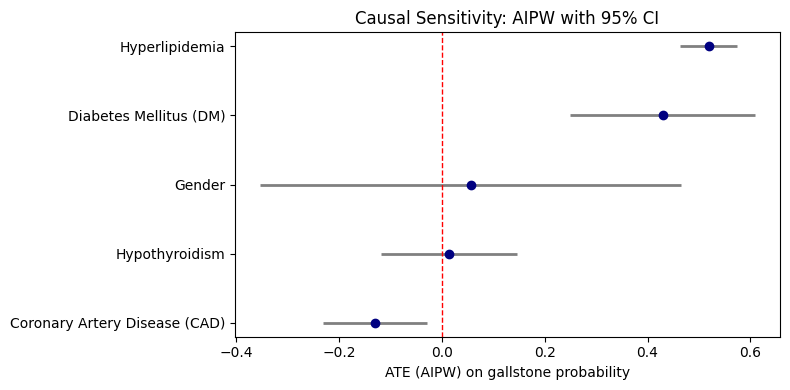

In [37]:
if len(causal_result_df) > 0:
    plot_df = causal_result_df.sort_values('ate_aipw').reset_index(drop=True)
    y_pos = np.arange(len(plot_df))

    plt.figure(figsize=(8, max(3, 0.6 * len(plot_df) + 1)))
    plt.hlines(y=y_pos, xmin=plot_df['ci_low'], xmax=plot_df['ci_high'], color='gray', lw=2)
    plt.plot(plot_df['ate_aipw'], y_pos, 'o', color='navy')
    plt.axvline(0.0, color='red', linestyle='--', lw=1)
    plt.yticks(y_pos, plot_df['treatment'])
    plt.xlabel('ATE (AIPW) on gallstone probability')
    plt.title('Causal Sensitivity: AIPW with 95% CI')
    plt.tight_layout()
    plt.show()

Top treatment: Hyperlipidemia
Real AIPW ATE: 0.519
Placebo p-value: 0.035 (smaller is stronger)


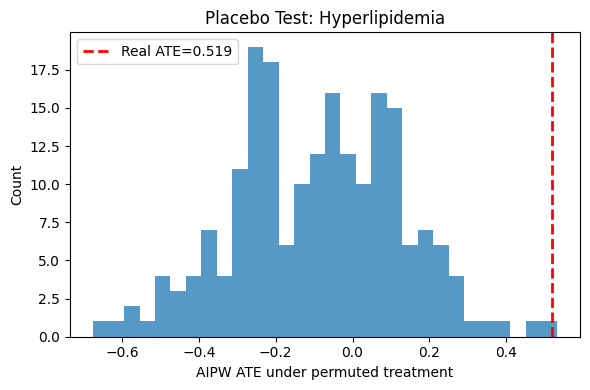

In [38]:
def placebo_test(df_in, treatment, outcome_col, n_perm=200, seed=16):
    rng = np.random.default_rng(seed)
    real = estimate_ate_binary(df_in, treatment, outcome_col, n_splits=5, seed=seed)['ate_aipw']
    null_dist = []

    for _ in range(n_perm):
        tmp = df_in.copy()
        tmp[treatment] = rng.permutation(tmp[treatment].to_numpy())
        try:
            null_ate = estimate_ate_binary(tmp, treatment, outcome_col, n_splits=5, seed=seed)['ate_aipw']
            null_dist.append(null_ate)
        except Exception:
            continue

    null_dist = np.array(null_dist, dtype=float)
    p_val = (np.sum(np.abs(null_dist) >= abs(real)) + 1) / (len(null_dist) + 1)
    return real, null_dist, p_val

if len(causal_result_df) > 0:
    top_treatment = causal_result_df.iloc[0]['treatment']
    real_ate, null_ates, p_val = placebo_test(causal_df, top_treatment, OUTCOME_COL, n_perm=200, seed=RANDOM_STATE)

    print(f"Top treatment: {top_treatment}")
    print(f"Real AIPW ATE: {real_ate:.3f}")
    print(f"Placebo p-value: {p_val:.3f} (smaller is stronger)")

    plt.figure(figsize=(6, 4))
    plt.hist(null_ates, bins=30, alpha=0.75)
    plt.axvline(real_ate, color='red', linestyle='--', lw=2, label=f"Real ATE={real_ate:.3f}")
    plt.title(f"Placebo Test: {top_treatment}")
    plt.xlabel("AIPW ATE under permuted treatment")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()